In [2]:
import pandas as pd

In [4]:
# Import packages
import tensorflow.compat.v1 as tf
# Disable the default activate eager execution in TF v1.0
tf.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import KeyedVectors
import re
import gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryuska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
SAMPLE_USER=3

In [7]:
df_desc = pd.read_csv("./description-final.csv")

In [8]:
df_desc.columns = ["Title", "Description", "MovieID"]

In [9]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
movies_df.columns = ["MovieID","Title","Genres"]

In [10]:
movies_df.shape

(62423, 3)

In [11]:
movies_df = pd.merge(movies_df, df_desc, on="MovieID", how="inner")

In [12]:
movies_df

,MovieID,Title_x,Genres,Title_y,Description
0,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...
1,99515,Yesterday's Enemy (1959),Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ..."
2,99517,Young People (1940),Drama,Young People,A show-business family leaves the Great White ...
3,99519,Henry (2010),Comedy,Henry,Henry is a cynical man who owns a musical inst...
4,99521,"Incruste, L' (a.k.a. L'Incruste, fallait pas l...",Comedy,L'incruste,A small crook manages to crash at a musician's...
...,...,...,...,...,...
43322,209157,We (2018),Drama,Wij,Eight teens - four guys and four girls - are t...
43323,209159,Window of the Soul (2001),Documentary,Janela da Alma,Nineteen people with differing degrees of visu...
43324,209163,Bad Poems (2018),Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af..."
43325,209169,A Girl Thing (2001),(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...


In [13]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('./ml-25m/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [14]:
# Rename the columns in the dataset
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [15]:
# Create a separate indexing column as we cannot use MovieID
movies_df['List Index'] = movies_df.index

In [16]:
# Merge movies with ratings by MovieID as foreign key
merged_df = movies_df.merge(ratings_df, on='MovieID')

In [17]:
merged_df

,MovieID,Title_x,Genres,Title_y,Description,List Index,UserID,Rating,Timestamp
0,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,31889,3.5,1479996552
1,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,40511,3.0,1504119072
2,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,63752,3.0,1495133656
3,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,72315,2.0,1455251735
4,99513,Waiting for Lightning (2012),Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,75309,5.0,1558738197
...,...,...,...,...,...,...,...,...,...
1699841,209157,We (2018),Drama,Wij,Eight teens - four guys and four girls - are t...,43322,119571,1.5,1574280748
1699842,209159,Window of the Soul (2001),Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,115835,3.0,1574280985
1699843,209163,Bad Poems (2018),Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,6964,4.5,1574284913
1699844,209169,A Girl Thing (2001),(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,119571,3.0,1574291826


In [18]:
# Drop columns
merged_df = merged_df.drop('Timestamp', axis=1).drop(['Title_x',], axis=1).drop('Genres', axis=1)

In [19]:
# Get user groups
userGroup = merged_df.groupby('UserID')

In [20]:
def preprocess_data(userGroup, movies_df):
    # No. of users in training
    UsedUsers = 1000
    # create list
    trX = []
    # for each user in the group
    for userID, curUser in userGroup:
        # Temp variable that stores every movie's rating
        temp = [0] * len(movies_df)
        # For Each movie in the curUser's movie list
        for num, movie in curUser.iterrows():
            # Divide ratings by 5 and store it
            temp[int(movie['List Index'])] = movie['Rating'] / 5

        # Now add the list of ratings into the training list
        trX.append(temp)
        # Check to see if we finished adding in the amount of users for training
        if UsedUsers == 0:
            break
        UsedUsers -= 1
    return trX

In [21]:
# Return normalized user ratings into a list
trX = preprocess_data(userGroup, movies_df)

In [22]:
def rbm(movies_df):
    n_hid = 100  # Number of hidden layers
    n_vis = len(movies_df)  # Number of visible layers

    # Create respective placeholder variables for storing visible and hidden layer biases and weights
    vb = tf.placeholder("float", [n_vis])  # Number of unique movies
    hb = tf.placeholder("float", [n_hid])  # Number of features
    W = tf.placeholder("float", [n_vis, n_hid])  # Weights that connect the hidden and visible layers

    # Pre-process the input data
    v0 = tf.placeholder("float", [None, n_vis])
    _h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

    # Reconstruct the pre-processed input data (Sigmoid and ReLU activation functions are used)
    _v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
    v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
    h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

    # Set RBM training parameters
    alpha = 0.1  # Set learning rate
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)  # Set positive gradients
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)  # Set negative gradients

    # Calculate contrastive divergence to maximize
    CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

    # Create methods to update the weights and biases
    update_w = W + alpha * CD
    update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
    update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

    # Set error function (RMSE)
    err = v0 - v1
    err_sum = tf.sqrt(tf.reduce_mean(err**2))

    # Initialize variables
    cur_w = np.zeros([n_vis, n_hid], np.float32)  # Current weight
    cur_vb = np.zeros([n_vis], np.float32)  # Current visible unit biases
    cur_hb = np.zeros([n_hid], np.float32)  # Current hidden unit biases
    prv_w = np.zeros([n_vis, n_hid], np.float32)  # Previous weight
    prv_vb = np.zeros([n_vis], np.float32)  # Previous visible unit biases
    prv_hb = np.zeros([n_hid], np.float32)  # Previous hidden unit biases

    return v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum

In [23]:
# Return variables from the RBM implementation
v0, W, vb, hb, update_w, prv_w, prv_vb, prv_hb, update_vb, update_hb, cur_w, cur_vb, cur_hb, err_sum = rbm(movies_df)

Instructions for updating:
Use `tf.cast` instead.


In [24]:
# Initialize TensorFlow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train RBM with 50 epochs and batches of size 512
nb_epoch = 50
batch_size_ = 512
errors = []

2023-03-13 15:50:12.062373: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-13 15:50:12.071845: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [25]:
for i in range(nb_epoch):
    print("Current epoch: ", i)
    for start, end in zip(range(0, len(trX), batch_size_), range(batch_size_, len(trX), batch_size_)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print("Current RMSE error: ", errors[-1])

Current epoch:  0
Current RMSE error:  0.51218635
Current epoch:  1
Current RMSE error:  0.4994824
Current epoch:  2
Current RMSE error:  0.4861266
Current epoch:  3
Current RMSE error:  0.470139
Current epoch:  4
Current RMSE error:  0.4570995
Current epoch:  5
Current RMSE error:  0.43999198
Current epoch:  6
Current RMSE error:  0.42431143
Current epoch:  7
Current RMSE error:  0.40797734
Current epoch:  8
Current RMSE error:  0.39223272
Current epoch:  9
Current RMSE error:  0.3783418
Current epoch:  10
Current RMSE error:  0.36188304
Current epoch:  11
Current RMSE error:  0.34795967
Current epoch:  12
Current RMSE error:  0.334852
Current epoch:  13
Current RMSE error:  0.32372913
Current epoch:  14
Current RMSE error:  0.3117165
Current epoch:  15
Current RMSE error:  0.3024861
Current epoch:  16
Current RMSE error:  0.29462445
Current epoch:  17
Current RMSE error:  0.2869767
Current epoch:  18
Current RMSE error:  0.2810782
Current epoch:  19
Current RMSE error:  0.2761529
Cur

Text(0.5, 0, 'Number of Epochs')

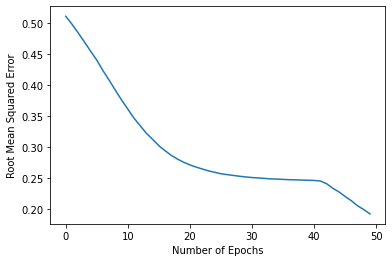

In [24]:
plt.plot(errors)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Epochs')

In [26]:
len(trX)

1001

In [27]:
# Selecting the input user
inputUser = [trX[SAMPLE_USER]]

In [29]:
# Feed in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [36]:
# We can then list the 100 most recommended movies for our mock user by sorting it by their scores given by our model
scored_movies_df_1 = movies_df
scored_movies_df_1["Recommendation Score"] = rec[0]
print("\n")
scored_movies_df_1 = scored_movies_df_1.drop(['Title_x'],axis=1)
scored_movies_df_1.columns = ['MovieID', 'Genres', 'Title','Description','ListIndex','Recommendation Score']
scored_movies_df_1.sort_values(["Recommendation Score"], ascending=False).head(100)

,MovieID,Genres,Title,Description,ListIndex,Recommendation Score
23490,164179,Sci-Fi,Arrival,A linguist works with the military to communic...,23490,1.000000
637,102445,Action|Adventure|Sci-Fi|IMAX,Star Trek Into Darkness,After the crew of the Enterprise find an unsto...,637,1.000000
5975,122920,Action|Sci-Fi|Thriller,Captain America: Civil War,Political involvement in the Avengers' affairs...,5975,1.000000
5974,122918,Action|Adventure|Sci-Fi,Guardians of the Galaxy Vol. 2,The Guardians struggle to keep together as a t...,5974,1.000000
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,1.000000
...,...,...,...,...,...,...
11254,136020,Action|Adventure|Crime,Spectre,A cryptic message from James Bond's past sends...,11254,0.996383
24553,166534,Drama|Horror|Thriller,Split,Three girls are kidnapped by a man with a diag...,24553,0.996022
34401,187541,Action|Adventure|Animation|Children,Incredibles 2,The Incredibles family takes on a new mission ...,34401,0.994015
29781,177593,Crime|Drama,"Three Billboards Outside Ebbing, Missouri",A mother personally challenges the local autho...,29781,0.993301


In [37]:
scored_movies_df_1.shape

(43327, 6)

In [248]:
#predicted rating

In [38]:
# Now we can find all the movies that our mock user has watched before
movies_df_1 = merged_df[merged_df['UserID'] == SAMPLE_USER]

In [39]:
movies_df_1

,MovieID,Title_y,Description,List Index,UserID,Rating
41325,101864,Oblivion,A veteran assigned to extract Earth's remainin...,519,3,4.0
54122,102125,Iron Man Three,When Tony Stark's world is torn apart by a for...,582,3,4.0
65172,102407,The Great Gatsby,"A writer and wall street trader, Nick, finds h...",626,3,4.0
69887,102445,Star Trek Into Darkness,After the crew of the Enterprise find an unsto...,637,3,4.0
80745,102686,The Hangover Part III,When one of their own is kidnapped by an angry...,671,3,3.0
...,...,...,...,...,...,...
1498742,176371,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...,29206,3,4.5
1541392,179819,Star Wars: Episode VIII - The Last Jedi,The Star Wars saga continues as new heroes and...,30787,3,3.5
1562837,182823,Bright,A detective must work with an Orc to find a po...,32197,3,3.0
1597216,187541,Incredibles 2,The Incredibles family takes on a new mission ...,34401,3,3.5


In [60]:
userItemProfile = movies_df_1.merge(scored_movies_df_1, on="MovieID", how="inner")

In [ ]:
userItemProfile=userItemProfile.drop(['Title_y', 'Description_x','List Index'],axis=1)

In [63]:
userItemProfile

,MovieID,UserID,Rating,Genres,Title,Description_y,ListIndex,Recommendation Score
0,101864,3,4.0,Action|Adventure|Sci-Fi|IMAX,Oblivion,A veteran assigned to extract Earth's remainin...,519,1.000000
1,102125,3,4.0,Action|Sci-Fi|Thriller|IMAX,Iron Man Three,When Tony Stark's world is torn apart by a for...,582,1.000000
2,102407,3,4.0,Drama,The Great Gatsby,"A writer and wall street trader, Nick, finds h...",626,1.000000
3,102445,3,4.0,Action|Adventure|Sci-Fi|IMAX,Star Trek Into Darkness,After the crew of the Enterprise find an unsto...,637,1.000000
4,102686,3,3.0,Comedy,The Hangover Part III,When one of their own is kidnapped by an angry...,671,0.257360
...,...,...,...,...,...,...,...,...
110,176371,3,4.5,Sci-Fi,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...,29206,0.999999
111,179819,3,3.5,Action|Adventure|Fantasy|Sci-Fi,Star Wars: Episode VIII - The Last Jedi,The Star Wars saga continues as new heroes and...,30787,0.921751
112,182823,3,3.0,Action|Crime|Fantasy,Bright,A detective must work with an Orc to find a po...,32197,0.097769
113,187541,3,3.5,Action|Adventure|Animation|Children,Incredibles 2,The Incredibles family takes on a new mission ...,34401,0.994015


In [64]:
userItemProfile.columns = ['MovieID','UserID','Rating','Genres','Title','Description','List Index', 'Recommendation Score']

In [65]:
userItemProfile

,MovieID,UserID,Rating,Genres,Title,Description,List Index,Recommendation Score
0,101864,3,4.0,Action|Adventure|Sci-Fi|IMAX,Oblivion,A veteran assigned to extract Earth's remainin...,519,1.000000
1,102125,3,4.0,Action|Sci-Fi|Thriller|IMAX,Iron Man Three,When Tony Stark's world is torn apart by a for...,582,1.000000
2,102407,3,4.0,Drama,The Great Gatsby,"A writer and wall street trader, Nick, finds h...",626,1.000000
3,102445,3,4.0,Action|Adventure|Sci-Fi|IMAX,Star Trek Into Darkness,After the crew of the Enterprise find an unsto...,637,1.000000
4,102686,3,3.0,Comedy,The Hangover Part III,When one of their own is kidnapped by an angry...,671,0.257360
...,...,...,...,...,...,...,...,...
110,176371,3,4.5,Sci-Fi,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...,29206,0.999999
111,179819,3,3.5,Action|Adventure|Fantasy|Sci-Fi,Star Wars: Episode VIII - The Last Jedi,The Star Wars saga continues as new heroes and...,30787,0.921751
112,182823,3,3.0,Action|Crime|Fantasy,Bright,A detective must work with an Orc to find a po...,32197,0.097769
113,187541,3,3.5,Action|Adventure|Animation|Children,Incredibles 2,The Incredibles family takes on a new mission ...,34401,0.994015


In [333]:
# We merge all the movies that our mock users has watched with the predicted scores based on his historical data
merged_df_1 = scored_movies_df_1.merge(movies_df_1, on='MovieID', how='outer')
print("\n")
merged_df_1.sort_values(["Recommendation Score"], ascending=False).head(25)


,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
23490,164179,Sci-Fi,Arrival,A linguist works with the military to communic...,23490,1.0,Arrival,A linguist works with the military to communic...,23490.0,3.0,4.0
637,102445,Action|Adventure|Sci-Fi|IMAX,Star Trek Into Darkness,After the crew of the Enterprise find an unsto...,637,1.0,Star Trek Into Darkness,After the crew of the Enterprise find an unsto...,637.0,3.0,4.0
5975,122920,Action|Sci-Fi|Thriller,Captain America: Civil War,Political involvement in the Avengers' affairs...,5975,1.0,Captain America: Civil War,Political involvement in the Avengers' affairs...,5975.0,3.0,3.5
5974,122918,Action|Adventure|Sci-Fi,Guardians of the Galaxy Vol. 2,The Guardians struggle to keep together as a t...,5974,1.0,Guardians of the Galaxy Vol. 2,The Guardians struggle to keep together as a t...,5974.0,3.0,4.0
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,1.0,NaN,NaN,NaN,NaN,NaN
5971,122912,Action|Adventure|Sci-Fi,Avengers: Infinity War,The Avengers and their allies must be willing ...,5971,1.0,Avengers: Infinity War,The Avengers and their allies must be willing ...,5971.0,3.0,3.5
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,1.0,NaN,NaN,NaN,NaN,NaN
16663,148626,Drama,The Big Short,In 2006-2007 a group of investors bet against ...,16663,1.0,The Big Short,In 2006-2007 a group of investors bet against ...,16663.0,3.0,4.0
5965,122900,Action|Adventure|Sci-Fi,Ant-Man,Armed with a super-suit with the astonishing a...,5965,1.0,Ant-Man,Armed with a super-suit with the astonishing a...,5965.0,3.0,4.0
5962,122892,Action|Adventure|Sci-Fi,Avengers: Age of Ultron,When Tony Stark and Bruce Banner try to jump-s...,5962,1.0,Avengers: Age of Ultron,When Tony Stark and Bruce Banner try to jump-s...,5962.0,3.0,3.5


In [48]:
merged_df_1.shape

(43327, 11)

In [67]:
userItemProfile

,MovieID,UserID,Rating,Genres,Title,Description,List Index,Recommendation Score
0,101864,3,4.0,Action|Adventure|Sci-Fi|IMAX,Oblivion,A veteran assigned to extract Earth's remainin...,519,1.000000
1,102125,3,4.0,Action|Sci-Fi|Thriller|IMAX,Iron Man Three,When Tony Stark's world is torn apart by a for...,582,1.000000
2,102407,3,4.0,Drama,The Great Gatsby,"A writer and wall street trader, Nick, finds h...",626,1.000000
3,102445,3,4.0,Action|Adventure|Sci-Fi|IMAX,Star Trek Into Darkness,After the crew of the Enterprise find an unsto...,637,1.000000
4,102686,3,3.0,Comedy,The Hangover Part III,When one of their own is kidnapped by an angry...,671,0.257360
...,...,...,...,...,...,...,...,...
110,176371,3,4.5,Sci-Fi,Blade Runner 2049,Young Blade Runner K's discovery of a long-bur...,29206,0.999999
111,179819,3,3.5,Action|Adventure|Fantasy|Sci-Fi,Star Wars: Episode VIII - The Last Jedi,The Star Wars saga continues as new heroes and...,30787,0.921751
112,182823,3,3.0,Action|Crime|Fantasy,Bright,A detective must work with an Orc to find a po...,32197,0.097769
113,187541,3,3.5,Action|Adventure|Animation|Children,Incredibles 2,The Incredibles family takes on a new mission ...,34401,0.994015


In [ ]:
merged_df_1 = merged_df_1.drop(['Title_x', 'Description_y','Title_y_y'], axis=1)


In [ ]:
merged_df_1.sort_values(by='Rating', ascending=False)

In [330]:
merged_df_1

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.030839,NaN,NaN,NaN,NaN,NaN
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.032303,NaN,NaN,NaN,NaN,NaN
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.031734,NaN,NaN,NaN,NaN,NaN
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.035145,NaN,NaN,NaN,NaN,NaN
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.028680,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43322,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.030204,NaN,NaN,NaN,NaN,NaN
43323,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.033024,NaN,NaN,NaN,NaN,NaN
43324,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.028383,NaN,NaN,NaN,NaN,NaN
43325,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.036857,NaN,NaN,NaN,NaN,NaN


In [324]:
rbm_result = merged_df_1

In [325]:
rbm_result

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.030839,NaN,NaN,NaN,NaN,NaN
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.032303,NaN,NaN,NaN,NaN,NaN
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.031734,NaN,NaN,NaN,NaN,NaN
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.035145,NaN,NaN,NaN,NaN,NaN
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.028680,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43322,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.030204,NaN,NaN,NaN,NaN,NaN
43323,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.033024,NaN,NaN,NaN,NaN,NaN
43324,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.028383,NaN,NaN,NaN,NaN,NaN
43325,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.036857,NaN,NaN,NaN,NaN,NaN


In [334]:
rbm_result['UserID'] = rbm_result['UserID'].fillna(3)

In [335]:
rbm_result

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID,Rating
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.030839,NaN,NaN,NaN,3.0,NaN
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.032303,NaN,NaN,NaN,3.0,NaN
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.031734,NaN,NaN,NaN,3.0,NaN
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.035145,NaN,NaN,NaN,3.0,NaN
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.028680,NaN,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43322,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.030204,NaN,NaN,NaN,3.0,NaN
43323,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.033024,NaN,NaN,NaN,3.0,NaN
43324,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.028383,NaN,NaN,NaN,3.0,NaN
43325,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.036857,NaN,NaN,NaN,3.0,NaN


In [69]:
userItemProfile = userItemProfile.sort_values(by='Rating', ascending=False)
userItemProfile = userItemProfile[userItemProfile['Rating'] >= 3.5]
userItemProfile

,MovieID,UserID,Rating,Genres,Title,Description,List Index,Recommendation Score
87,136449,3,5.0,Action|Animation|Sci-Fi,Kôkaku kidôtai 2.0,A hacker known as the Puppet Master is hunted ...,11410,0.185621
48,112556,3,5.0,Drama|Thriller,Gone Girl,With his wife's disappearance having become th...,2763,1.000000
47,112552,3,5.0,Drama,Whiplash,A promising young drummer enrolls at a cut-thr...,2761,1.000000
57,115713,3,4.5,Drama|Sci-Fi|Thriller,Ex Machina,A young programmer is selected to participate ...,3499,1.000000
17,104243,3,4.5,Action|Sci-Fi|Thriller|IMAX,Riddick,"Left for dead on a sun-scorched planet, Riddic...",1022,0.885075
...,...,...,...,...,...,...,...,...
66,122892,3,3.5,Action|Adventure|Sci-Fi,Avengers: Age of Ultron,When Tony Stark and Bruce Banner try to jump-s...,5962,1.000000
67,122896,3,3.5,(no genres listed),Pirates of the Caribbean: Dead Men Tell No Tales,Captain Jack Sparrow is pursued by old rival C...,5963,0.192548
24,106489,3,3.5,Adventure|Fantasy|IMAX,The Hobbit: The Desolation of Smaug,"The dwarves, along with Bilbo Baggins and Gand...",1507,1.000000
111,179819,3,3.5,Action|Adventure|Fantasy|Sci-Fi,Star Wars: Episode VIII - The Last Jedi,The Star Wars saga continues as new heroes and...,30787,0.921751


In [70]:
df_cbf = merged_df_1[merged_df_1.isna().any(axis=1)]
df_cbf=df_cbf.drop('Rating', axis=1)

In [71]:
df_cbf

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID
0,99513,Documentary,Waiting for Lightning,A documentary on pro skateboarder Danny Way's ...,0,0.030839,NaN,NaN,NaN,NaN
1,99515,Drama|War,Yesterday's Enemy,"In World War II, during the Japanese invasion ...",1,0.032303,NaN,NaN,NaN,NaN
2,99517,Drama,Young People,A show-business family leaves the Great White ...,2,0.031734,NaN,NaN,NaN,NaN
3,99519,Comedy,Henry,Henry is a cynical man who owns a musical inst...,3,0.035145,NaN,NaN,NaN,NaN
4,99521,Comedy,L'incruste,A small crook manages to crash at a musician's...,4,0.028680,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
43322,209157,Drama,Wij,Eight teens - four guys and four girls - are t...,43322,0.030204,NaN,NaN,NaN,NaN
43323,209159,Documentary,Janela da Alma,Nineteen people with differing degrees of visu...,43323,0.033024,NaN,NaN,NaN,NaN
43324,209163,Comedy|Drama,Rossz versek,"33-years old Tamás Merthner is heartbroken, af...",43324,0.028383,NaN,NaN,NaN,NaN
43325,209169,(no genres listed),A Girl Thing,An NYC shrink sees four different women with d...,43325,0.036857,NaN,NaN,NaN,NaN


In [72]:
df_cbf = df_cbf.sort_values(by='Recommendation Score', ascending=False)

In [73]:
df_cbf

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score,Title_y,Description_y,List Index,UserID
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000,NaN,NaN,NaN,NaN
25353,168250,Horror,Get Out,A young African-American visits his white girl...,25353,1.000000,NaN,NaN,NaN,NaN
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,1.000000,NaN,NaN,NaN,NaN
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,1.000000,NaN,NaN,NaN,NaN
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,1.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
23567,164342,Drama,Paranoia,A man is under the illusion he is a wanted war...,23567,0.024695,NaN,NaN,NaN,NaN
14654,143882,Action|Drama|Thriller,Operator,When the daughter of veteran 911 call center o...,14654,0.024606,NaN,NaN,NaN,NaN
7994,128277,Comedy,Fric-Frac,Marcel works as assistant to a jeweller whose ...,7994,0.024496,NaN,NaN,NaN,NaN
39757,199532,Comedy|Romance,Love at First Sight,A young woman named Shirley befriends a lonely...,39757,0.024312,NaN,NaN,NaN,NaN


In [74]:
df_cbf=df_cbf.drop(['List Index','UserID', 'Description_y', 'Title_y'],axis=1)
df_cbf

,MovieID,Genres,Title,Description_x,ListIndex,Recommendation Score
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000
25353,168250,Horror,Get Out,A young African-American visits his white girl...,25353,1.000000
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,1.000000
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,1.000000
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,1.000000
...,...,...,...,...,...,...
23567,164342,Drama,Paranoia,A man is under the illusion he is a wanted war...,23567,0.024695
14654,143882,Action|Drama|Thriller,Operator,When the daughter of veteran 911 call center o...,14654,0.024606
7994,128277,Comedy,Fric-Frac,Marcel works as assistant to a jeweller whose ...,7994,0.024496
39757,199532,Comedy|Romance,Love at First Sight,A young woman named Shirley befriends a lonely...,39757,0.024312


In [75]:
df_cbf.columns = ['MovieID','Genres','Title','Description','List Index', 'Recommendation Score']
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000
25353,168250,Horror,Get Out,A young African-American visits his white girl...,25353,1.000000
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,1.000000
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,1.000000
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,1.000000
...,...,...,...,...,...,...
23567,164342,Drama,Paranoia,A man is under the illusion he is a wanted war...,23567,0.024695
14654,143882,Action|Drama|Thriller,Operator,When the daughter of veteran 911 call center o...,14654,0.024606
7994,128277,Comedy,Fric-Frac,Marcel works as assistant to a jeweller whose ...,7994,0.024496
39757,199532,Comedy|Romance,Love at First Sight,A young woman named Shirley befriends a lonely...,39757,0.024312


In [76]:
print(df_cbf['Description'].isna().sum())

1


In [77]:
df_cbf = df_cbf.dropna(subset=['Description'])

In [78]:
print(df_cbf['Description'].isna().sum())

0


In [79]:

def _removeNonAscii(s):
    return "".join(i.encode('ascii', 'ignore').decode() for i in s )

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [80]:
df_cbf['Cleaned'] = df_cbf['Description'].apply(_removeNonAscii)

df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func = make_lower_case)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func = remove_stop_words)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func=remove_punctuation)
df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func=remove_html)


/var/folders/wp/36kdrjm51z92ythp0vp8xp5m0000gn/T/ipykernel_12654/4268372762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cbf['Cleaned'] = df_cbf['Description'].apply(_removeNonAscii)
/var/folders/wp/36kdrjm51z92ythp0vp8xp5m0000gn/T/ipykernel_12654/4268372762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cbf['Cleaned'] = df_cbf.Cleaned.apply(func = make_lower_case)
/var/folders/wp/36kdrjm51z92ythp0vp8xp5m0000gn/T/ipykernel_12654/4268372762.py:4: SettingWithCopyWarning: 
A value is trying t

In [81]:
userItemProfile['Cleaned'] = userItemProfile['Description'].apply(_removeNonAscii)

userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func = make_lower_case)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func = remove_stop_words)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func=remove_punctuation)
userItemProfile['Cleaned'] = userItemProfile.Cleaned.apply(func=remove_html)

In [82]:
corpusCBF = []
for words in df_cbf['Cleaned']:
    corpusCBF.append(words.split())


In [83]:
model = gensim.models.Word2Vec(corpusCBF, min_count=1)

In [84]:
user_pref = ""
for i,data in userItemProfile.iterrows():
    user_pref += " " + data['Cleaned']

In [85]:
print(user_pref)

 hacker known puppet master hunted female cyborg cop partner film revised version kkaku kidtai 1995 wife s disappearance become focus intense media circus man sees spotlight turned suspected may innocent promising young drummer enrolls cut throat music conservatory dreams greatness mentored instructor stop nothing realize student s potential young programmer selected participate ground breaking experiment synthetic intelligence evaluating human qualities highly advanced humanoid a i left dead sun scorched planet riddick finds alien race predators activating emergency beacon alerts two ships one carrying new breed mercenary captained man riddick s past young blade runner k s discovery long buried secret leads track former blade runner rick deckard who s missing thirty years based true story jordan belfort rise wealthy stock broker living high life fall involving crime corruption federal government foul mouthed mutant mercenary wade wilson a k a deadpool assembles team fellow mutant rogu

In [86]:
corpus_user_pref = []
corpus_user_pref.append(user_pref.split())

In [87]:
corpus_user_pref[0]

['hacker',
 'known',
 'puppet',
 'master',
 'hunted',
 'female',
 'cyborg',
 'cop',
 'partner',
 'film',
 'revised',
 'version',
 'kkaku',
 'kidtai',
 '1995',
 'wife',
 's',
 'disappearance',
 'become',
 'focus',
 'intense',
 'media',
 'circus',
 'man',
 'sees',
 'spotlight',
 'turned',
 'suspected',
 'may',
 'innocent',
 'promising',
 'young',
 'drummer',
 'enrolls',
 'cut',
 'throat',
 'music',
 'conservatory',
 'dreams',
 'greatness',
 'mentored',
 'instructor',
 'stop',
 'nothing',
 'realize',
 'student',
 's',
 'potential',
 'young',
 'programmer',
 'selected',
 'participate',
 'ground',
 'breaking',
 'experiment',
 'synthetic',
 'intelligence',
 'evaluating',
 'human',
 'qualities',
 'highly',
 'advanced',
 'humanoid',
 'a',
 'i',
 'left',
 'dead',
 'sun',
 'scorched',
 'planet',
 'riddick',
 'finds',
 'alien',
 'race',
 'predators',
 'activating',
 'emergency',
 'beacon',
 'alerts',
 'two',
 'ships',
 'one',
 'carrying',
 'new',
 'breed',
 'mercenary',
 'captained',
 'man',
 'ri

In [88]:
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000,city anthropomorphic animals rookie bunny cop ...
25353,168250,Horror,Get Out,A young African-American visits his white girl...,25353,1.000000,young african american visits white girlfriend...
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,1.000000,newly crowned queen elsa accidentally uses pow...
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,1.000000,washed up superhero actor attempts revive fadi...
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,1.000000,wisecracking mercenary gets experimented becom...
...,...,...,...,...,...,...,...
23567,164342,Drama,Paranoia,A man is under the illusion he is a wanted war...,23567,0.024695,man illusion wanted war criminal
14654,143882,Action|Drama|Thriller,Operator,When the daughter of veteran 911 call center o...,14654,0.024606,daughter veteran 911 call center operator pame...
7994,128277,Comedy,Fric-Frac,Marcel works as assistant to a jeweller whose ...,7994,0.024496,marcel works assistant jeweller whose bossy da...
39757,199532,Comedy|Romance,Love at First Sight,A young woman named Shirley befriends a lonely...,39757,0.024312,young woman named shirley befriends lonely bli...


In [89]:
def get_similarity_score(text):
    return model.wv.n_similarity(corpus_user_pref[0], text.split())

In [93]:
df_cbf = df_cbf.sort_values(by='Recommendation Score', ascending=False)
df_cbf = df_cbf[df_cbf['Recommendation Score'] >= 0.7]
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000,city anthropomorphic animals rookie bunny cop ...
14045,142488,Thriller,Spotlight,The true story of how the Boston Globe uncover...,14045,1.000000,true story boston globe uncovered massive scan...
1160,104879,Drama|Mystery|Thriller,Prisoners,When Keller Dover's daughter and her friend go...,1160,1.000000,keller dover s daughter friend go missing take...
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,1.000000,newly crowned queen elsa accidentally uses pow...
2663,112183,Comedy|Drama,Birdman or (The Unexpected Virtue of Ignorance),A washed-up superhero actor attempts to revive...,2663,1.000000,washed up superhero actor attempts revive fadi...
5967,122904,Action|Adventure|Comedy|Sci-Fi,Deadpool,A wisecracking mercenary gets experimented on ...,5967,1.000000,wisecracking mercenary gets experimented becom...
1364,105844,Drama,12 Years a Slave,"In the antebellum United States, Solomon North...",1364,1.000000,antebellum united states solomon northup free ...
5973,122916,Action|Adventure|Sci-Fi,Thor: Ragnarok,"Imprisoned on the planet Sakaar, Thor must rac...",5973,1.000000,imprisoned planet sakaar thor must race time r...
3389,115149,Action|Thriller,John Wick,An ex-hit-man comes out of retirement to track...,3389,1.000000,ex hit man comes retirement track gangsters ki...
4648,119145,Action|Adventure|Comedy|Crime,Kingsman: The Secret Service,A spy organisation recruits a promising street...,4648,1.000000,spy organisation recruits promising street kid...


In [94]:
df_cbf['Similarity Score'] = df_cbf.Cleaned.apply(get_similarity_score)

In [95]:
df_cbf = df_cbf.sort_values(by='Similarity Score',ascending=False)

In [96]:
df_cbf

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score
37794,195159,Action|Adventure|Animation|Sci-Fi,Spider-Man: Into the Spider-Verse,Teen Miles Morales becomes the Spider-Man of h...,37794,0.999923,teen miles morales becomes spider man universe...,0.973582
1581,106916,Crime|Drama,American Hustle,"A con man, Irving Rosenfeld, along with his se...",1581,0.979383,con man irving rosenfeld along seductive partn...,0.973140
4498,118696,Adventure|Fantasy,The Hobbit: The Battle of the Five Armies,Bilbo and company are forced to engage in a wa...,4498,0.999996,bilbo company forced engage war array combatan...,0.969048
18088,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000,city anthropomorphic animals rookie bunny cop ...,0.968223
8016,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,1.000000,dead wyoming winter bounty hunter prisoner fin...,0.967034
3403,115210,Action|Drama|War,Fury,A grizzled tank commander makes tough decision...,3403,0.999999,grizzled tank commander makes tough decisions ...,0.967022
14045,142488,Thriller,Spotlight,The true story of how the Boston Globe uncover...,14045,1.000000,true story boston globe uncovered massive scan...,0.966856
1542,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,1.000000,newly crowned queen elsa accidentally uses pow...,0.966538
14426,143355,Action|Adventure|Fantasy,Wonder Woman,When a pilot crashes and tells of conflict in ...,14426,0.999997,pilot crashes tells conflict outside world dia...,0.965254
24518,166461,Adventure|Animation|Children|Comedy|Fantasy,Moana,"In Ancient Polynesia, when a terrible curse in...",24518,0.999999,ancient polynesia terrible curse incurred demi...,0.963876


In [116]:
avg_ratings = ratings_df.groupby('MovieID')['Rating'].mean()

In [118]:

movies_with_ratings = pd.merge(df_cbf, avg_ratings, on="MovieID", how="inner")

In [119]:
movies_with_ratings.columns= ['MovieID', 'Genres','Title','Description','List Index', 'Recommendation Score','Cleaned','Similarity Score', 'AVG Rating']

In [161]:
movies_with_ratings

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating
0,195159,Action|Adventure|Animation|Sci-Fi,Spider-Man: Into the Spider-Verse,Teen Miles Morales becomes the Spider-Man of h...,37794,0.999923,teen miles morales becomes spider man universe...,0.973582,4.111345
1,106916,Crime|Drama,American Hustle,"A con man, Irving Rosenfeld, along with his se...",1581,0.979383,con man irving rosenfeld along seductive partn...,0.973140,3.543882
2,118696,Adventure|Fantasy,The Hobbit: The Battle of the Five Armies,Bilbo and company are forced to engage in a wa...,4498,0.999996,bilbo company forced engage war array combatan...,0.969048,3.510419
3,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000,city anthropomorphic animals rookie bunny cop ...,0.968223,3.893646
4,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,1.000000,dead wyoming winter bounty hunter prisoner fin...,0.967034,3.866135
5,115210,Action|Drama|War,Fury,A grizzled tank commander makes tough decision...,3403,0.999999,grizzled tank commander makes tough decisions ...,0.967022,3.728212
6,142488,Thriller,Spotlight,The true story of how the Boston Globe uncover...,14045,1.000000,true story boston globe uncovered massive scan...,0.966856,4.076438
7,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,1.000000,newly crowned queen elsa accidentally uses pow...,0.966538,3.485042
8,143355,Action|Adventure|Fantasy,Wonder Woman,When a pilot crashes and tells of conflict in ...,14426,0.999997,pilot crashes tells conflict outside world dia...,0.965254,3.629300
9,166461,Adventure|Animation|Children|Comedy|Fantasy,Moana,"In Ancient Polynesia, when a terrible curse in...",24518,0.999999,ancient polynesia terrible curse incurred demi...,0.963876,3.849899


In [121]:
train_ratings = ratings_df.sample(frac=0.8, random_state=1)
test_ratings = ratings_df.drop(train_ratings.index)

In [157]:
train_df = userItemProfile

In [122]:
user_means = train_ratings.groupby('UserID')['Rating'].mean()

In [123]:
train_ratings['Rating Adjusted'] = train_ratings['Rating'] - train_ratings['UserID'].map(user_means)

In [124]:
movie_weights = train_ratings.groupby('MovieID')['Rating Adjusted'].sum() / train_ratings.groupby('MovieID')['Rating Adjusted'].count()

In [126]:
test_ratings['Predicted Rating'] = test_ratings.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [164]:
movies_with_ratings['UserID'] = 3

In [170]:
movies_with_ratings['Predicted Rating'] = movies_with_ratings.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [174]:
movies_with_ratings.head(1)

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating
0,195159,Action|Adventure|Animation|Sci-Fi,Spider-Man: Into the Spider-Verse,Teen Miles Morales becomes the Spider-Man of h...,37794,0.999923,teen miles morales becomes spider man universe...,0.973582,4.111345,3,4.056816


In [172]:
def binRating(rating):
    if rating >= 3.5:
        return 1
    else:
        return 0

In [177]:
movies_with_ratings['BIN AVG Rating'] = movies_with_ratings['AVG Rating'].apply(binRating)
movies_with_ratings['BIN Predicted Rating'] = movies_with_ratings['Predicted Rating'].apply(binRating)

In [180]:
movies_with_ratings.head()

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating,BIN AVG Rating,BIN Predicted Rating
0,195159,Action|Adventure|Animation|Sci-Fi,Spider-Man: Into the Spider-Verse,Teen Miles Morales becomes the Spider-Man of h...,37794,0.999923,teen miles morales becomes spider man universe...,0.973582,4.111345,3,4.056816,1,1
1,106916,Crime|Drama,American Hustle,"A con man, Irving Rosenfeld, along with his se...",1581,0.979383,con man irving rosenfeld along seductive partn...,0.973140,3.543882,3,3.682897,1,1
2,118696,Adventure|Fantasy,The Hobbit: The Battle of the Five Armies,Bilbo and company are forced to engage in a wa...,4498,0.999996,bilbo company forced engage war array combatan...,0.969048,3.510419,3,3.606013,1,1
3,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000,city anthropomorphic animals rookie bunny cop ...,0.968223,3.893646,3,3.859331,1,1
4,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,1.000000,dead wyoming winter bounty hunter prisoner fin...,0.967034,3.866135,3,3.916493,1,1


In [181]:

def precision_recall_at_k(recommended_items, relevant_items, k):
    """
    Calculate precision@k and recall@k for a recommendation system.
    
    Args:
    - recommended_items: list of recommended items
    - relevant_items: list of relevant items
    - k: integer, number of items to consider
    
    Returns:
    - precision@k: float, precision at k
    - recall@k: float, recall at k
    """
    
    recommended_items = recommended_items[:k]
    
    # Calculate precision@k
    precision = len(set(recommended_items).intersection(set(relevant_items))) / float(k)
    
    # Calculate recall@k
    recall = len(set(recommended_items).intersection(set(relevant_items))) / float(len(relevant_items))
    
    return precision, recall


In [185]:
k = 10
precision, recall = precision_recall_at_k(movies_with_ratings['BIN Predicted Rating'], movies_with_ratings['BIN AVG Rating'], k)

print('Precision@{}: {:.2f}'.format(k, precision))
print('Recall@{}: {:.2f}'.format(k, recall))

Precision@10: 0.10
Recall@10: 0.02


In [345]:
rbm_result['Predicted Rating'] = rbm_result.apply(lambda row: user_means.get(row['UserID'], 0) + movie_weights.get(row['MovieID'], 0), axis=1)

In [336]:

rbm_result = pd.merge(rbm_result, avg_ratings, on="MovieID", how="inner")

In [339]:
rbm_result = rbm_result.drop(['Title_y', 'Description_y', 'List Index', 'Rating_x'],axis=1)

In [341]:
rbm_result.columns = ['MovieID','Genres','Title','Description', 'List Index', 'Recommendation Score', 'UserID', 'AVG Rating']

In [350]:
rbm_result.shape

(39992, 11)

In [347]:
rbm_result['BIN Predicted Rating'] = rbm_result['Predicted Rating'].apply(binRating)
rbm_result['BIN AVG Rating'] = rbm_result['AVG Rating'].apply(binRating)


In [356]:
rbm_result.shape

(39992, 11)

In [362]:
k = 10
precision, recall = precision_recall_at_k(rbm_result['BIN Predicted Rating'], rbm_result['BIN AVG Rating'], k)

print('Precision@{}: {:.2f}'.format(k, precision))
print('Recall@{}: {:.2f}'.format(k, recall))

Precision@10: 0.20
Recall@10: 0.00


In [239]:
movies_with_ratings['Relevant Score'] = 0.7 * movies_with_ratings['Recommendation Score'] + 0.3 * movies_with_ratings['Similarity Score']

In [240]:
movies_with_ratings = movies_with_ratings.sort_values('Relevant Score', ascending=False)
movies_with_ratings

,MovieID,Genres,Title,Description,List Index,Recommendation Score,Cleaned,Similarity Score,AVG Rating,UserID,Predicted Rating,BIN AVG Rating,BIN Predicted Rating,Relevant Score
0,195159,Action|Adventure|Animation|Sci-Fi,Spider-Man: Into the Spider-Verse,Teen Miles Morales becomes the Spider-Man of h...,37794,0.999923,teen miles morales becomes spider man universe...,0.973582,4.111345,3,4.056816,1,1,0.992021
2,118696,Adventure|Fantasy,The Hobbit: The Battle of the Five Armies,Bilbo and company are forced to engage in a wa...,4498,0.999996,bilbo company forced engage war array combatan...,0.969048,3.510419,3,3.606013,1,1,0.990711
3,152081,Action|Adventure|Animation|Children|Comedy,Zootopia,"In a city of anthropomorphic animals, a rookie...",18088,1.000000,city anthropomorphic animals rookie bunny cop ...,0.968223,3.893646,3,3.859331,1,1,0.990467
4,128360,Western,The Hateful Eight,"In the dead of a Wyoming winter, a bounty hunt...",8016,1.000000,dead wyoming winter bounty hunter prisoner fin...,0.967034,3.866135,3,3.916493,1,1,0.990110
5,115210,Action|Drama|War,Fury,A grizzled tank commander makes tough decision...,3403,0.999999,grizzled tank commander makes tough decisions ...,0.967022,3.728212,3,3.757974,1,1,0.990106
6,142488,Thriller,Spotlight,The true story of how the Boston Globe uncover...,14045,1.000000,true story boston globe uncovered massive scan...,0.966856,4.076438,3,4.088891,1,1,0.990057
7,106696,Adventure|Animation|Comedy|Fantasy|Musical|Rom...,Frozen,When the newly crowned Queen Elsa accidentally...,1542,1.000000,newly crowned queen elsa accidentally uses pow...,0.966538,3.485042,3,3.565502,0,1,0.989961
8,143355,Action|Adventure|Fantasy,Wonder Woman,When a pilot crashes and tells of conflict in ...,14426,0.999997,pilot crashes tells conflict outside world dia...,0.965254,3.629300,3,3.703064,1,1,0.989574
9,166461,Adventure|Animation|Children|Comedy|Fantasy,Moana,"In Ancient Polynesia, when a terrible curse in...",24518,0.999999,ancient polynesia terrible curse incurred demi...,0.963876,3.849899,3,3.845390,1,1,0.989162
10,103335,Animation|Children|Comedy|IMAX,Despicable Me 2,"When Gru, the world's most super-bad turned su...",822,0.999990,gru world s super bad turned super dad recruit...,0.963480,3.557723,3,3.641532,1,1,0.989037


In [191]:
def dcg_at_k(r, k):
    """
    Calculate DCG (Discounted Cumulative Gain) at k for a list of item ratings.
    
    Args:
    - r: list of item ratings
    - k: integer, number of items to consider
    
    Returns:
    - DCG@k: float, Discounted Cumulative Gain at k
    """
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.0

def ndcg_at_k(r, k):
    """
    Calculate NDCG (Normalized Discounted Cumulative Gain) at k for a list of item ratings.
    
    Args:
    - r: list of item ratings
    - k: integer, number of items to consider
    
    Returns:
    - NDCG@k: float, Normalized Discounted Cumulative Gain at k
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.0
    return dcg_at_k(r, k) / dcg_max


In [297]:
# ndcg hybrid
movies_with_ratings = movies_with_ratings.sort_values('Relevant Score', ascending=False)
item_ratings = movies_with_ratings['AVG Rating'] # item ratings in the ranked order
k = 5
ndcg = ndcg_at_k(item_ratings, k)

print('NDCG@{}: {:.2f}'.format(k, ndcg))

NDCG@5: 0.87


In [218]:
df_cbf = pd.merge(df_cbf, avg_ratings, on="MovieID", how="inner")

In [301]:
# ndcg rbm
movies_with_ratings = movies_with_ratings.sort_values('Recommendation Score', ascending=False)
item_ratings = movies_with_ratings['AVG Rating'] # item ratings in the ranked order
k = 5
ndcg = ndcg_at_k(item_ratings, k)

print('NDCG@{}: {:.2f}'.format(k, ndcg))

NDCG@5: 0.83
